# DCGAN from scratch
@hyyoka

## 드라이브 연결

In [ ]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive')
# 경로 설정
import os
os.chdir('/content/gdrive/My Drive/')

Mounted at /content/gdrive


## 패키지 임포트

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

## MNIST 데이터 불러오기
기존의 MNIST 손글씨 데이터의 경우 1x28x28 이미지 -> dcgan 모델 적용을 위해 1x64x64 이미지로 크기 조절 (물론 28x28이미지도 사용가능하지만 네트워크 구조 수정 필요)  
처음 데이터를 사용할때는 download=True로 데이터를 다운 받기  
이후에 사용할때는 데이터가 이미 다운되있으므로 download=False로 바꿔서 사용

In [ ]:
# MNIST dataset
dataroot = './mnist_data/'
imageSize = 64 # the height / width of the input image to network

dataset = dset.MNIST(root = dataroot, download= True,
                     transform = transforms.Compose([
                                                     transforms.Resize(imageSize), #이미지 64x64로 크기 변환
                                                     transforms.ToTensor(), #텐서자료형으로 변환
                                                     transforms.Normalize((0.5,), (0.5,)), #노말라이즈를 통해 -1.~1.의 값을 갖게 변환
                     ]))

### 데이터 확인하기

In [ ]:
print('number of training data: ', len(dataset)) #데이터 수 확인
image,_ = dataset[0]

print('Image')
print('========================================')
print('shape of this image\t:', image.shape) #데이터 차원(모양)확인하기

number of training data:  60000
Image
shape of this image	: torch.Size([1, 64, 64])


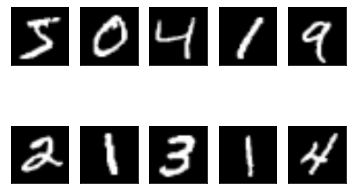

In [ ]:
# 학습 데이터 시각화
fig = plt.figure()

for i in range(10):
    image,_ = dataset[i]
    image = (image+1)/2
    image = image.squeeze()
    np_img = image.numpy()
    
    subplot = fig.add_subplot(2, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(np_img, cmap = 'gray')

plt.show()

### 데이터 로더 정의

In [ ]:
# dataloader
batch_size = 128
workers = -1 # 최대한 많게 설정!

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle = True, num_workers = workers)

## device 정의

In [ ]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 신경망 

In [ ]:
#네트워크 하이퍼파라미터 설정
nc = 1 # number of color channels == image.size(0), 흑백이면 1/컬러면 3:rgb
nz = 100 #Size of z latent vector (size of generator input)
ngf = 64 # size of feature maps in generator
ndf = 64 # size of feature maps in discriminator

### 신경망 가중치 초기화 함수 정의
신경망의 가중치 초기화 방법에 대해 논문에 자세히 나와있습니다.  
다음 사이트는 파이토치에서 가중치 초기화에 관련된 글 입니다  
https://www.javaer101.com/ko/article/1010427.html

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 생성자 클래스

trasposed convolution 관련 자료: https://yonghyuc.wordpress.com/2019/08/08/transposed-convolutions-aka-deconvolution/

In [ ]:
# creating a RGB image with the same size as the training images
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # a series of strided two dimensional convolutional transpose layers
            # first
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # second
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # thrid
            nn.ConvTranspose2d(ngf*4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # fourth
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # final summary
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # output_size:  (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netG = Generator().to(device) # 생성자 객체 생성
netG.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 생성자 출력
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### 판별자 클래스

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # a series of Conv2d, BatchNorm2d, LeakyReLU layers
        # input_size: (nc) x 64 x 64
        self.main = nn.Sequential(
            # first
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            #  second
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # thrid
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # fourth
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # final
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # outputs the final probability
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [ ]:
netD = Discriminator().to(device) # 생성자 객체 생성
netD.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 판별자 출력
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Loss Function & Optimizer

In [ ]:
# 손실함수
criterion = nn.BCELoss()

real_label = 1.
fake_label = 0.

# optimizer hyperparameters
learning_rate =  0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

## Train
"빈칸"을 채우고, 각각의 변수 및 메소드가 무엇을 나태는지 혹은 어떻게 계산되는지를 주석으로 설명 부탁드립니다.  
참고하면 좋은 사이트: https://redstarhong.tistory.com/64

In [ ]:
num_epochs = 5
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        #### (1) Train the Discriminator ###
        # maximize log(D(x)) + log(1 - D(G(z)))

        netD.zero_grad() # 기울기 초기화
        
        ## (1-1) construct a batch of real samples and forward, backward pass
        real_cpu = data[0].to(device) # real sample batch
        b_size = real_cpu.size(0) # 배치 사이즈!
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device) # from real sample이라는 label
        # Forward pass
        output = netD(real_cpu).view(-1)
        # loss
        errD_real = criterion(output, label)
        # Backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## (1-2) construct a batch of fake samples with the current generator
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label) # Generator가 만든 fake 이미지: label 0
        
        # fake에 대한 판별자 학습
        # Forward pass
        output = netD(fake.detach()).view(-1)
        # loss
        errD_fake = criterion(output, label)
        # Backward pass
        errD_fake.backward()
        D_G_z1 = output.mean().item()

         # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ### (2) Train the Generator ###
        # maximize log(D(G(z)))

        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake).view(-1) # 새로 학습된 판별자에 대한 현재 생성자의 성능 
        # 생성자는 이 결과값들을 real label과 최대한 가까워지게 하고 싶음
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # 학습 경과 출력
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, num_epochs, i, len(dataloader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

[0/5][0/469]	Loss_D: 1.8334	Loss_G: 8.1699	D(x): 0.3789	D(G(z)): 0.4596 / 0.0005
[0/5][50/469]	Loss_D: 0.0599	Loss_G: 8.5217	D(x): 0.9624	D(G(z)): 0.0150 / 0.0003
[0/5][100/469]	Loss_D: 0.0136	Loss_G: 7.5812	D(x): 0.9947	D(G(z)): 0.0082 / 0.0007
[0/5][150/469]	Loss_D: 0.0072	Loss_G: 7.7010	D(x): 0.9997	D(G(z)): 0.0069 / 0.0005
[0/5][200/469]	Loss_D: 0.0011	Loss_G: 8.6544	D(x): 0.9996	D(G(z)): 0.0007 / 0.0002
[0/5][250/469]	Loss_D: 0.0037	Loss_G: 7.2207	D(x): 0.9994	D(G(z)): 0.0031 / 0.0008
[0/5][300/469]	Loss_D: 0.0022	Loss_G: 7.4697	D(x): 0.9994	D(G(z)): 0.0016 / 0.0006
[0/5][350/469]	Loss_D: 0.0021	Loss_G: 7.3500	D(x): 0.9998	D(G(z)): 0.0019 / 0.0007
[0/5][400/469]	Loss_D: 0.0029	Loss_G: 7.1987	D(x): 0.9996	D(G(z)): 0.0025 / 0.0008
[0/5][450/469]	Loss_D: 0.0013	Loss_G: 7.8664	D(x): 0.9995	D(G(z)): 0.0008 / 0.0004
[1/5][0/469]	Loss_D: 0.0008	Loss_G: 7.9633	D(x): 0.9998	D(G(z)): 0.0006 / 0.0004
[1/5][50/469]	Loss_D: 0.0007	Loss_G: 8.1350	D(x): 0.9999	D(G(z)): 0.0006 / 0.0003
[1/5][100/

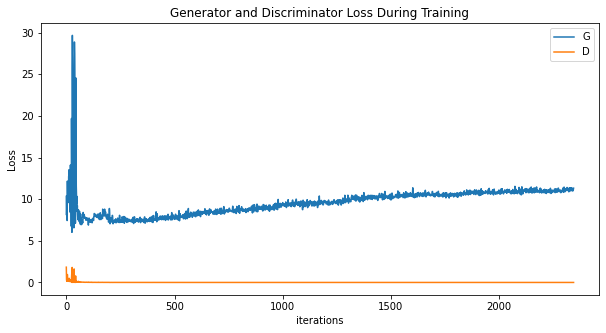

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()